In [2]:
import pandas as pd
import numpy as np

In [3]:
data: pd.DataFrame = pd.read_csv("../creditcard.csv")
data["Class"] = np.where(data["Class"] <= 0, 0, 1)

data.shape


(284807, 31)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Split data into training/testing
X = data.drop("Class", axis=1).to_numpy()
Y = data["Class"].to_numpy()

# Split the data into training and testing sets (80% train, 20% test)
np.random.seed(42)  # For reproducibility
training_data_mask = np.random.rand(len(data)) < 0.8
X_train = X[training_data_mask]
Y_train = Y[training_data_mask]
X_test = X[~training_data_mask]
Y_test = Y[~training_data_mask]

Kmeans Function Definitions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


def compute_inertia(X, centroids):
    labels = closest_centroid(X, centroids)
    inertia = 0.0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i]) ** 2)
    return inertia

def elbow_method(X, k_range, max_iters=100):
    inertias = []

    for k in k_range:
        centroids = kmeans(X, k=k, max_iters=max_iters)
        inertia = compute_inertia(X, centroids)
        inertias.append(inertia)
        print(f"k={k}, Inertia={inertia:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

def normalize(X):
    """Z-score normalization."""
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

def initialize_centroids(X, k):
    """Randomly choose k points from X as initial centroids."""
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def closest_centroid(X, centroids):
    """Return index of closest centroid for each point in X."""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # shape (n_samples, k)
    return np.argmin(distances, axis=1)

def kmeans(X, k=10, max_iters=100, tol=0.0001):
    n_samples, n_features = X.shape
    centroids = initialize_centroids(X, k)

    for _ in range(max_iters):
        labels = closest_centroid(X, centroids)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = X[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                new_centroids[i] = X[np.random.choice(n_samples)]

        if np.linalg.norm(centroids - new_centroids) < tol:
            break

        centroids = new_centroids

    return centroids


def detect_anomalies(X, centroids, threshold_quantile=0.995):
    distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    threshold = np.quantile(distances, threshold_quantile)
    return distances > threshold, distances, threshold

def classification_report(y_true, y_pred, scores):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid divide-by-zero
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    auprc = average_precision_score(y_true, scores)


    print("=== Classification Report ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"auprc:  {auprc:.4f}")

Find best K with elbow method

k=5, Inertia=6006146.55
k=10, Inertia=5436152.25
k=15, Inertia=4945500.48
k=20, Inertia=4393828.44
k=25, Inertia=4190820.60
k=30, Inertia=4023038.47
k=35, Inertia=3868861.68
k=40, Inertia=3694230.91
k=45, Inertia=3548714.57


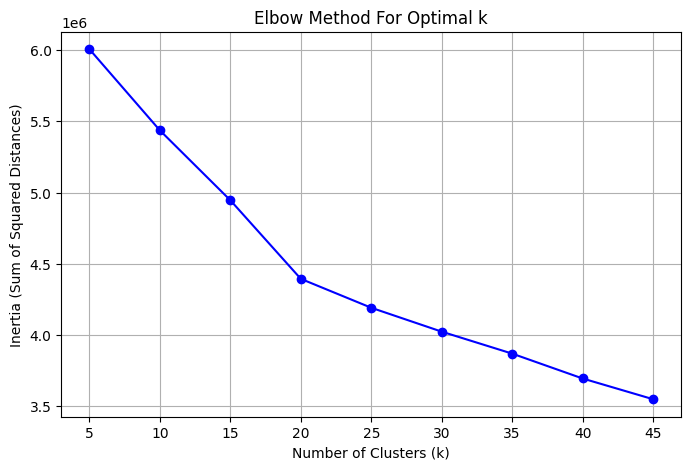

In [7]:
# Normalize your train and test sets
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

elbow_method(X_train_norm, k_range=range(5, 50, 5))

Run Kmeans and evaluation

In [8]:
k = 25
centroids = kmeans(X_train_norm, k=k, max_iters=100)

fraud_predictions, test_distances, threshold = detect_anomalies(X_test_norm, centroids)
classification_report(Y_test, fraud_predictions, test_distances)



=== Classification Report ===
Precision: 0.1049
Recall:    0.3488
F1 Score:  0.1613
Accuracy:  0.9945
auprc:  0.0828
